In [1]:
import numpy as np
import jax.numpy as jnp
import jax

from scipy.optimize import minimize
# from jax.scipy.optimize import minimize

import scoobpsf.jax_scoob as jscoob
import scoobpsf.jax_dm as jdm
from scoobpsf.imshows import *

from importlib import reload

Nact = 34
Nacts = 952
act_spacing = 300*u.um

pupil_diam = 6.75*u.mm
dm_fill_factor = 0.94
dm_active_diam = 0.0102

npix = 256
oversample = 8
N = int(npix*oversample)

pupil_pxscl = pupil_diam.to_value(u.m)/npix
wavelength = 650e-9

npsf = 200
psf_pixelscale_lamD = 1/4

from importlib import reload



Cupy unavailable; computations will not be performed using GPU with CuPy.
Unable to import ray; no parallelized propagation functionality available.


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Jax platform: cpu
Jax device: cpu


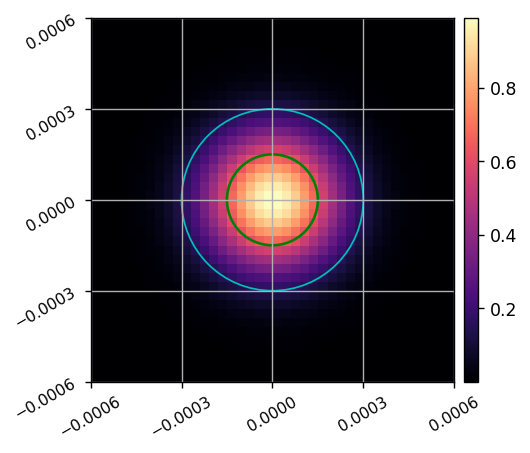

/home/kianmilani/miniconda3/envs/cpu311env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


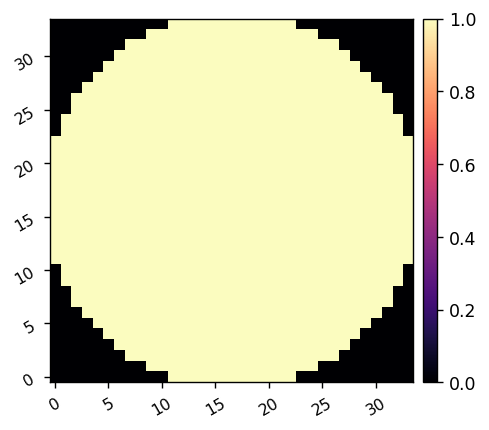

952


In [2]:
reload(jdm)
inf_fun, inf_sampling, inf_pixelscale = jdm.make_gaussian_inf_fun(sampling=10, Nacts_per_inf=4, plot=True)
inf_pixelscale = inf_pixelscale.to_value(u.m/u.pix)
dm_mask = jdm.make_dm_mask(plot=True)
print(dm_mask.sum())


In [3]:
reload(jscoob)
focal_grid = jscoob.make_focal_grid(npix,oversample)

Jax platform: cpu
Jax device: cpu
[-127.9375 -127.8125 -127.6875 ...  127.6875  127.8125  127.9375]


Jax platform: cpu
Jax device: cpu


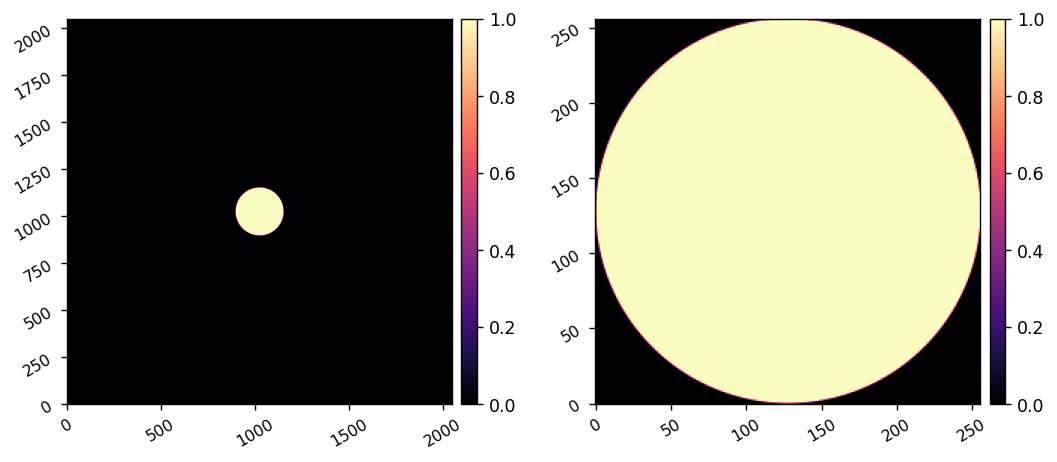

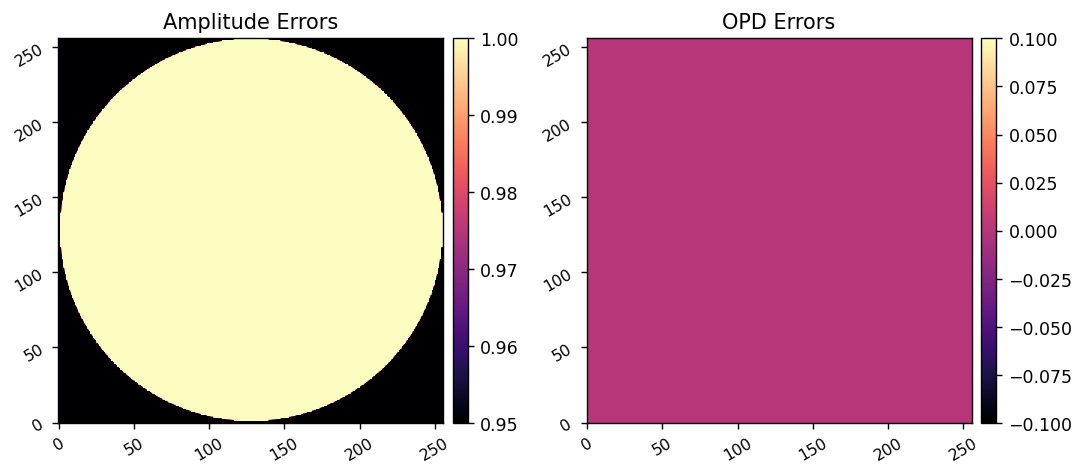

[-128.    -127.875 -127.75  ...  127.625  127.75   127.875]


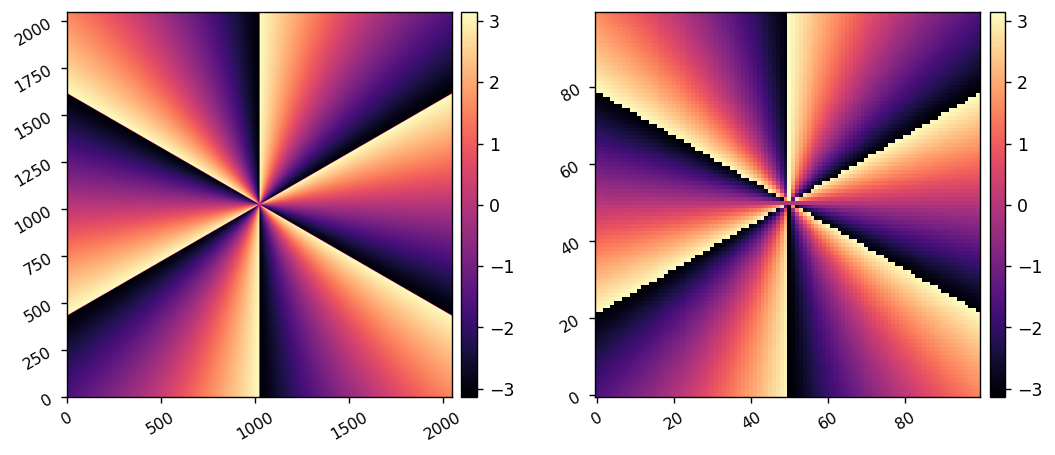

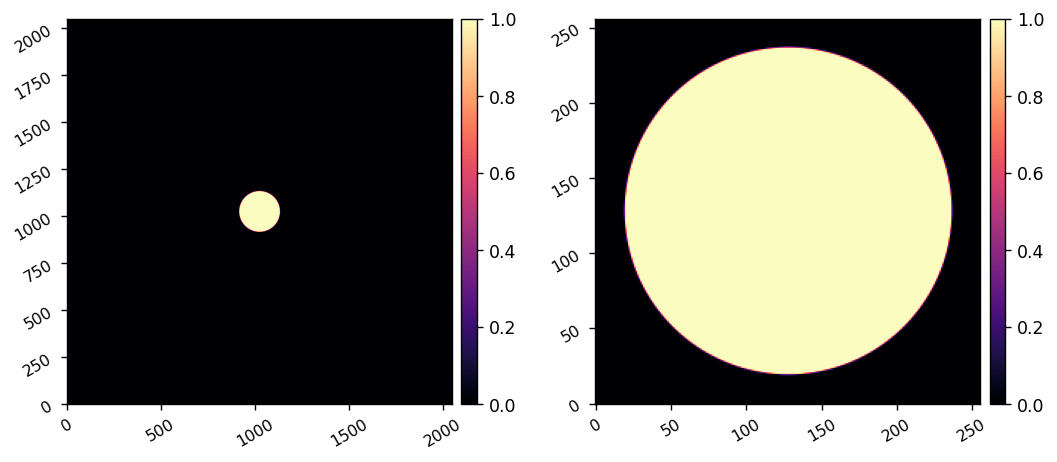

In [14]:
reload(jscoob)

pupil = jscoob.make_pupil(pupil_diam, npix, oversample)
imshow2(pupil, pupil, npix2=npix)

WFE = jscoob.generate_wfe(diam=pupil_diam,
                          # amp_rms=0*u.nm, opd_rms=0*u.nm,
                          amp_rms=0.0, amp_index=3.2, opd_rms=0*u.nm, opd_index=3.2,
                          npix=npix, oversample=oversample,)

imshow2(ensure_np_array(jnp.abs(WFE)), ensure_np_array(jnp.angle(WFE))/(2*np.pi)*wavelength, 
        'Amplitude Errors', 'OPD Errors',
        npix=npix,
        vmin1=0.95)

focal_grid = jscoob.make_focal_grid(npix,oversample)
vortex = jscoob.make_vortex_phase_mask(focal_grid)
imshow2(jnp.angle(vortex), jscoob.pad_or_crop(jnp.angle(vortex), 100))

lyot = jscoob.make_pupil(pupil_diam, npix, oversample, ratio=0.85)
imshow2(lyot, lyot, npix2=npix)


Jax platform: cpu
Jax device: cpu
8.010012515644554


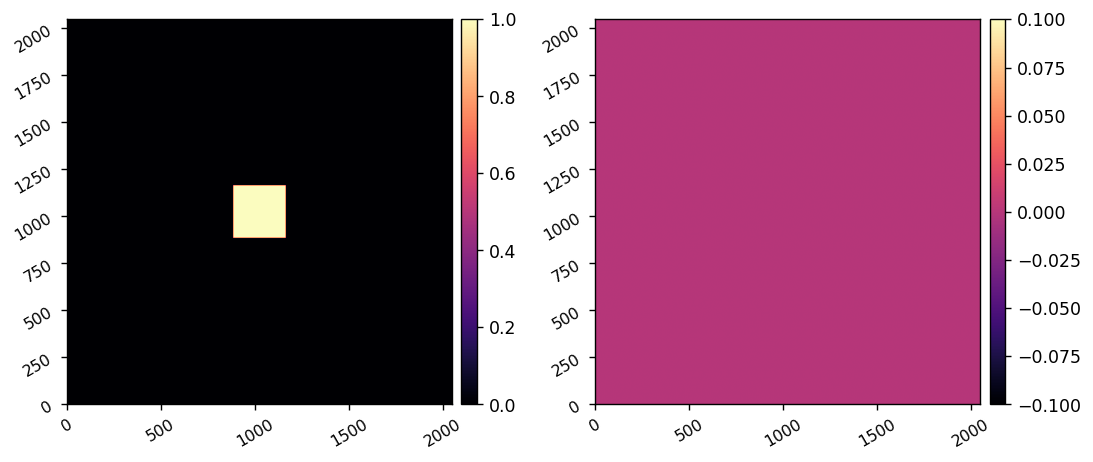

In [15]:
reload(jscoob)
reload(jdm)
command = jnp.zeros((Nact,Nact))

# command = 1e-8*jnp.array(np.random.randn(Nact,Nact))
# dm_phasor = phasor = jdm.get_phasor(command, 
#                                inf_fun, inf_sampling, 
#                                inf_pixelscale=inf_pixelscale*u.m/u.pix, 
#                                pixelscale=pixelscale,
#                                wavelength=wavelength*u.m)

dm_phasor = jscoob.get_dm_phasor(command, 
                                inf_fun, inf_sampling, inf_pixelscale*u.m/u.pix,
                                npix, dm_fill_factor,)
dm_phasor = jscoob.pad_or_crop(dm_phasor, N)
imshow2(jnp.abs(dm_phasor), jnp.angle(dm_phasor))

Jax platform: cpu
Jax device: cpu


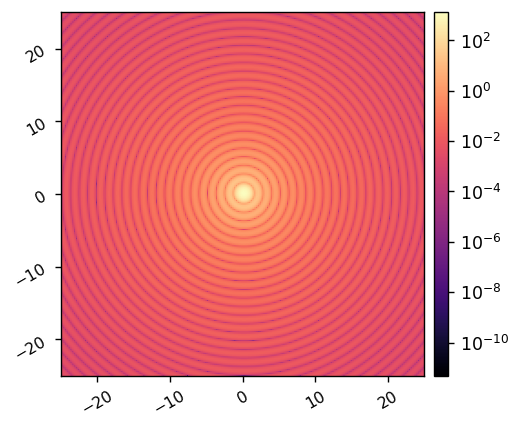

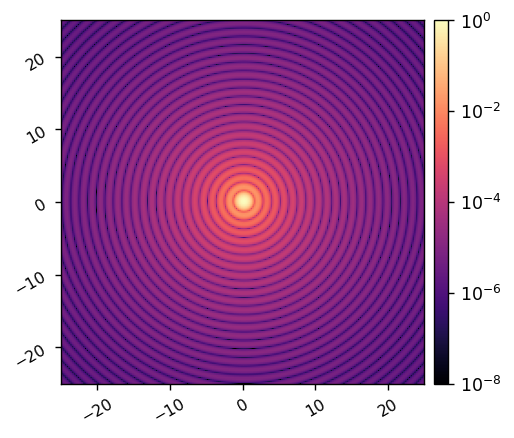

Jax platform: cpu
Jax device: cpu


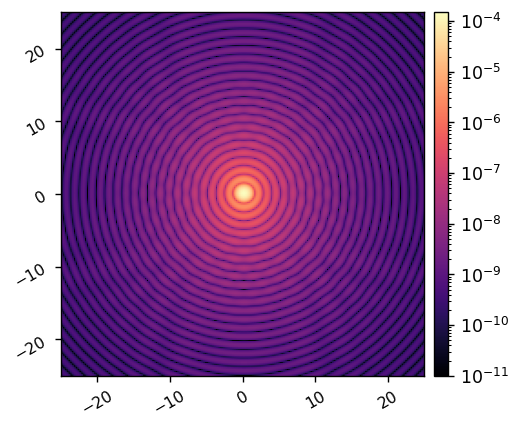

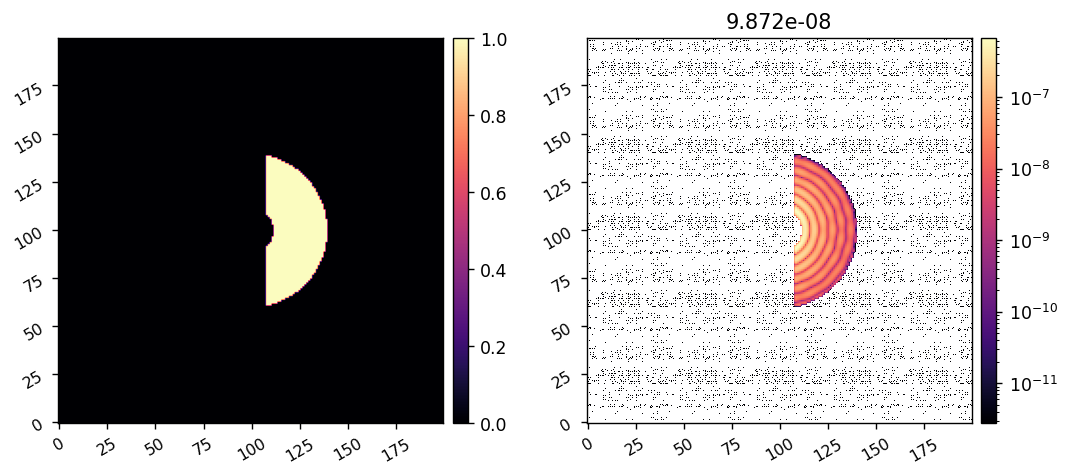

In [16]:
reload(jscoob)
# WFE = jnp.ones((N,N))
ref_unocc_im = jscoob.snap(pupil, WFE, dm_phasor, jnp.ones((N,N)), lyot,
                                    npix, oversample,
                                    npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
                                    plot=True)

Imax_ref = ref_unocc_im.max()

ref_Unocc_im = jscoob.snap(pupil, WFE, dm_phasor, jnp.ones((N,N)), lyot,
                            npix, oversample, 
                            npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
                            Imax_ref=Imax_ref,
                            plot=True, vmin=1e-8)

reload(jscoob)
ref_im = jscoob.snap(pupil, WFE, dm_phasor, vortex, lyot,
                    npix, oversample, 
                    npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
                    Imax_ref=Imax_ref,
                    plot=True, vmin=1e-11)

xim = (jnp.linspace(0, npsf-1, npsf) - npsf/2 +1/2)*psf_pixelscale_lamD
xim, yim = jnp.meshgrid(xim,xim)
rim = jnp.sqrt(xim**2 + yim**2)

control_mask = (rim > 3)*(rim < 10)*(xim>2)
rms_con = jnp.sqrt(jnp.mean(ref_im[control_mask]**2))
imshow2(control_mask, control_mask*ref_im, None, f'{rms_con:.3e}', lognorm2=True)

Jax platform: cpu
Jax device: cpu


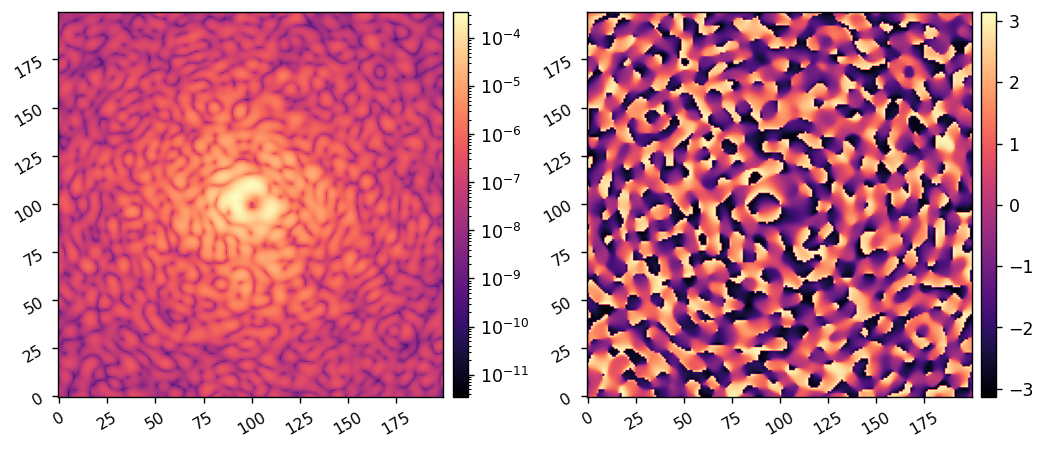

In [105]:
reload(jscoob)

current_command = jnp.zeros((Nact,Nact))

E_ab = jscoob.forward_model(pupil, WFE, dm_phasor, vortex, lyot,
                            npix, oversample, 
                            npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
                            Imax_ref=Imax_ref)
imshow2(jnp.abs(E_ab)**2, jnp.angle(E_ab), lognorm1=True)



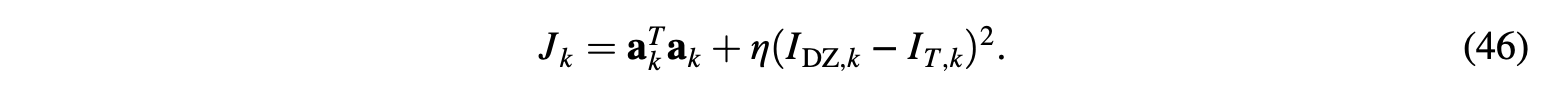

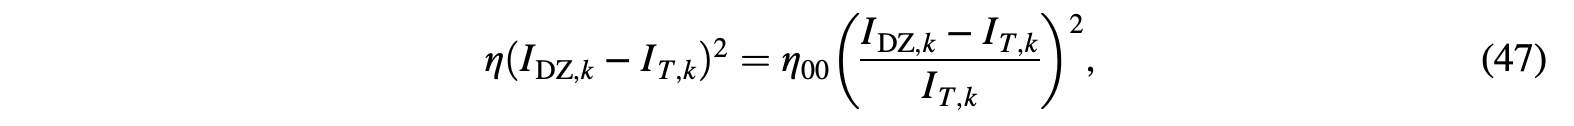

In [146]:
# def compute_E_DM(del_command):

#     dm_phasor = jscoob.get_dm_phasor(current_command, 
#                                      inf_fun, inf_sampling, inf_pixelscale*u.m/u.pix,
#                                      npix, dm_fill_factor,)
#     dm_phasor = jscoob.pad_or_crop(dm_phasor, N)

#     E_full = jscoob.forward_model(pupil, WFE, dm_phasor, vortex, lyot,
#                                     npix, oversample, 
#                                     npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
#                                     Imax_ref=Imax_ref)
    
#     tot_dm_phasor = jscoob.get_dm_phasor(current_command + del_command, 
#                                      inf_fun, inf_sampling, inf_pixelscale*u.m/u.pix,
#                                      npix, dm_fill_factor,)
#     tot_dm_phasor = jscoob.pad_or_crop(tot_dm_phasor, N)

#     E_DM = E_full - jscoob.forward_model(pupil, WFE, tot_dm_phasor, vortex, lyot,
#                                         npix, oversample, 
#                                         npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
#                                         Imax_ref=Imax_ref)

#     return E_DM

def compute_E_DM(del_command):
    
    # E_nom = jscoob.forward_model(pupil, jnp.ones((N,N)), jnp.ones((N,N)), vortex, lyot,
    #                                     npix, oversample, 
    #                                     npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
    #                                     Imax_ref=Imax_ref)
    
    del_dm_phasor = jscoob.get_dm_phasor(current_command + del_command, 
                                     inf_fun, inf_sampling, inf_pixelscale*u.m/u.pix,
                                     npix, dm_fill_factor,)
    del_dm_phasor = jscoob.pad_or_crop(del_dm_phasor, N)

    E_DM = jscoob.forward_model(pupil, jnp.ones((N,N)), del_dm_phasor, vortex, lyot,
                                        npix, oversample, 
                                        npsf=npsf, pixelscale_lamD=psf_pixelscale_lamD,
                                        Imax_ref=Imax_ref)

    return E_DM

def cost_fun(del_actuators, I_tar_ratio=1/3, eta_00=1):
    '''
    acts: the actuator vector we want to find an optimal solution for
    I_tar_ratio: ratio for the desired target irradiance based on current integrated irradiance
    eta_00: parameter that Scott understands more
    E_ab: current electric-field estimate
    '''
    del_command = jdm.map_actuators_to_command(del_actuators, dm_mask)
    E_DM = compute_E_DM(del_command)

    E_DZ = E_ab[control_mask] + E_DM[control_mask]
    I_DZ = (E_DZ.conj().dot(E_DZ)).real
    I_tar = I_tar_ratio * I_DZ
    J = del_actuators.T.dot(del_actuators) + eta_00 * ((I_DZ - I_tar)/I_tar)**2
    return J


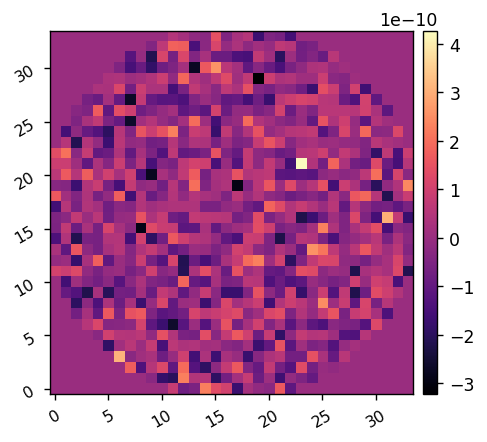

8.010012515644554


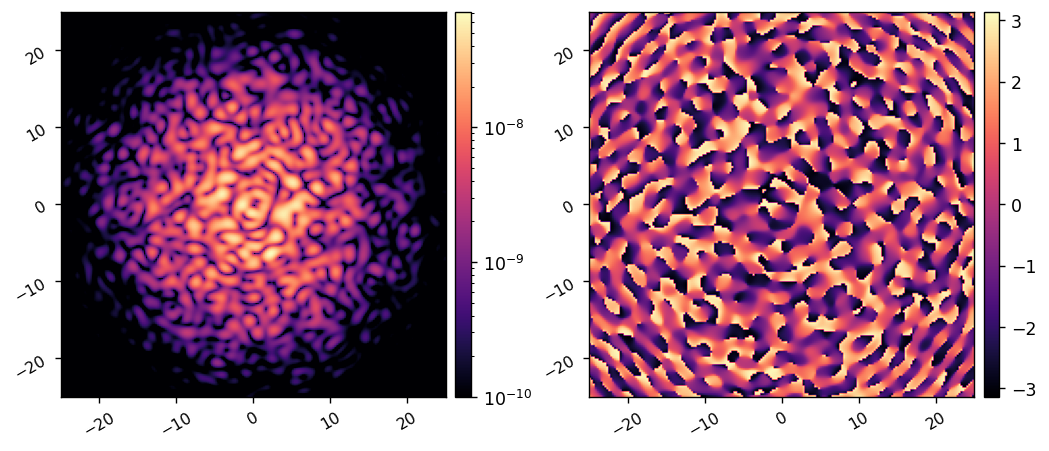

In [148]:
del_command = jdm.map_actuators_to_command(jnp.array(1e-10*np.random.randn(Nacts)), dm_mask)
imshow1(del_command)

E_DM = compute_E_DM(del_command)
imshow2(jnp.abs(E_DM)**2, jnp.angle(E_DM), lognorm1=True, vmin1=1e-10, pxscl=psf_pixelscale_lamD)

8.010012515644554
2.0 (952,)


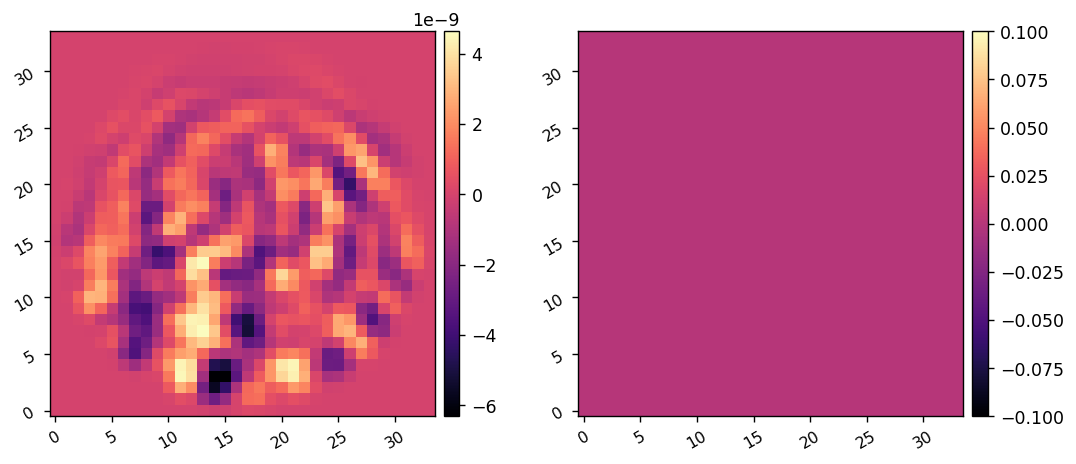

In [156]:
del_actuators = jnp.zeros(Nacts)
# del_actuators = jnp.array(np.random.randn(Nacts))*0.5e-9
del_command = jdm.map_actuators_to_command(del_actuators, dm_mask)
value_and_grad_of_cost = jax.value_and_grad(cost_fun, argnums=0)

val_and_grad = value_and_grad_of_cost(del_actuators, I_tar_ratio=0.5, eta_00=2)
print(val_and_grad[0], val_and_grad[1].shape)
grad_command = jdm.map_actuators_to_command(val_and_grad[1], dm_mask)
imshow2(grad_command/2, del_command)
# print(val_and_grad[1])

In [144]:
from scipy.optimize import minimize
res = minimize(value_and_grad_of_cost, jac=True, x0=jnp.zeros(Nacts), 
                method='L-BFGS-B', 
                tol=1e-8,
                options={'disp':True},
                )

8.010012515644554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00000D+00    |proj g|=  1.26050D-08


 This problem is unconstrained.


8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554
8.010012515644554

At iterate    1    f=  4.00000D+00    |proj g|=  8.05485D-19

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  952      1     13      1     0     0   8.055D-19   4.000D+00
  F =   4.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


True (952,)


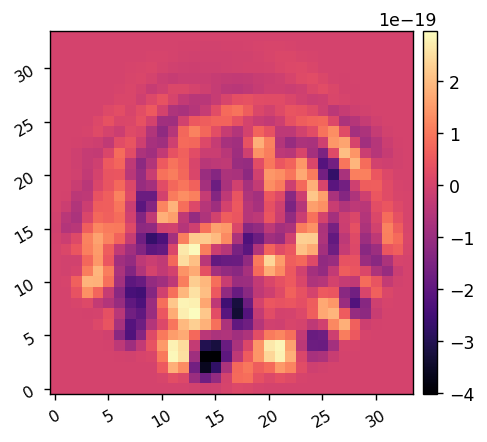

In [145]:
print(res.success, res.x.shape)
command = jdm.map_actuators_to_command(res.x, dm_mask)
imshow1(command)